# HW01
EE 538 Spring 2020 <br>
Analog Circuits for Sensor Systems <br>
University of Washington Electrical & Computer Engineering <br>

Due: April 11, 2020 <br>
Author: Kevin Egedy

In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def read_ltspice_tran(file_name):
    cols = []
    arrs = []
    with open(file_name, 'r',encoding='utf-8') as data:
        for i,line in enumerate(data):
            if i==0:
                cols = line.split()
                arrs = [[] for _ in cols]
                continue
            parts = line.split()
            for j,part in enumerate(parts):
                arrs[j].append(part)
    df = pd.DataFrame(arrs,dtype='float64')
    df = df.T
    df.columns = cols
    return df

In [3]:
def RoundNonZeroDecimal(num, place, rnd='ceil'):
    # Requires numpy library
    # Examples:
    #   RoundNonZeroDecimal(0.0004512,1,'floor') -> 0.0045
    #   RoundNonZeroDecimal(0.0004512,1,'ceil') -> 0.0046
    #
    tmp = num # implement so that num can be array
    mag = 0
    
    if rnd=='ceil':
        while(abs(tmp)<1):
            tmp*=10
            mag+=1
        for i in range(place):
            tmp*=10
            mag+=1
        return int(np.ceil([tmp])[0])/(10**(mag)) 
    
    if rnd=='floor':
        while(abs(tmp)<1):
            tmp*=10
            mag+=1
        for i in range(place):
            tmp*=10
            mag+=1
        return int(np.floor([tmp])[0])/(10**(mag))
    
    else:
        raise ValueError('Invalid argument')
        return None

<img src="images/Q1.png" width="600">

**Part A** Let $R=1000 \Omega$ for initial calculations

LP & HP filters: $f_{3\text{dB}} = \frac{1}{2\pi RC}$

$\begin{eqnarray}
\text{Choose } & f_{3\text{dB,HP}} \text{ to be 1 decade before 1Hz} \\
&0.1\text{Hz} = \frac{1}{2\pi R_1C_1} \Bigg|_{R_1=1000} \rightarrow C_1  &= 1.59\text{mA}
\end{eqnarray}$

$\begin{eqnarray}
\text{Choose } & f_{3\text{dB,LP}} \text{ to be 1 decade after 10KHz} \\
&100\text{KHz} = \frac{1}{2\pi R_2C_2} \Bigg|_{R_2=1000} \rightarrow C_2  &= 1.59\text{nA}
\end{eqnarray}$

**Part B**

*Notes:* HP/LP worst loading effect is determined by $R$.

To minimize loading effects choose $R_1,R_2$ to be at least 10*x* larger than $R_S$ and at least 10*x* smaller than $R_L$. LTspice was used to validate and tune these values. 

$R_1 = 100K \Omega, C_1 = 15.9 \mu \text{F}$ <br>
$R_2 = 10K \Omega, C_2 = 159 p \text{F}$

**Part C**

<img src="images/Q1c_ltspice.png" width="600">

In [4]:
def parallel(Z1,Z2):
    return 1/((1/Z1)+(1/Z2))

def voltdiv(Z1,Z2):
    return Z2/(Z1+Z2)

/home/kegedy/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


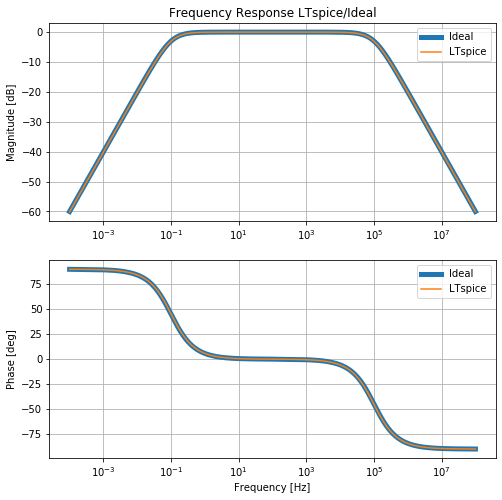

In [5]:
f1 = np.linspace(1e-4,1e2,100000)
f2 = np.linspace(1e2,1e8,100000)
f = np.concatenate((f1,f2))
w = 2*np.pi*f
RS = 100
R1 = 100e3
R2 = 10e3
RL = 10e6
C1 = 15.9e-6
C2 = 159e-12
tau1 = R1*C1
tau2 = R2*C2
#LP = 1/(1+1j*w*tau2)
#HP = (1j*w*tau1)/(1+1j*w*tau1)
ZC1 = 1/(1j*w*C1)
ZC2 = 1/(1j*w*C2)
H = voltdiv(RS+ZC1,R1)*voltdiv(R2,ZC2)

filepath = 'data/Q1.raw'
l = ltspice.Ltspice(filepath); l.parse() 
V1 = l.getData('V(vout)')
freq = l.getFrequency()

fig, axs = plt.subplots(2,figsize=(8,8))
axs[0].set_title('Frequency Response LTspice/Ideal')
axs[0].semilogx(f, 20*np.log10(abs(H)),linewidth=5,label='Ideal')
axs[0].semilogx(freq, 20*np.log10(abs(V1)),label='LTspice')
axs[0].set_ylabel('Magnitude [dB]')
axs[0].grid()
axs[0].legend()

axs[1].semilogx(f, np.angle(H,deg=True),linewidth=5, label='Ideal')
axs[1].semilogx(freq,np.angle(V1,deg=True),label='LTspice')
axs[1].set_ylabel('Phase [deg]')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].grid()
axs[1].legend()
plt.show();

<hr>

<img src="images/Q2.png" width="600">

<img src="images/BodeProperties.png" width="600">
*Reference: Circuit Analysis and Design by Fawwaz T. Ulaby, Michel M. Maharbiz, and Cynthia M. Fuse*

**Part A and B**

*Note:* <br>
*- parallel capacitance add like resistors in series* <br>
*- parallel resistance can be rearranged in any order*

Transfer Function: $K\frac{a}{s+a}$ and $a = \frac{1}{RC}, K = R$

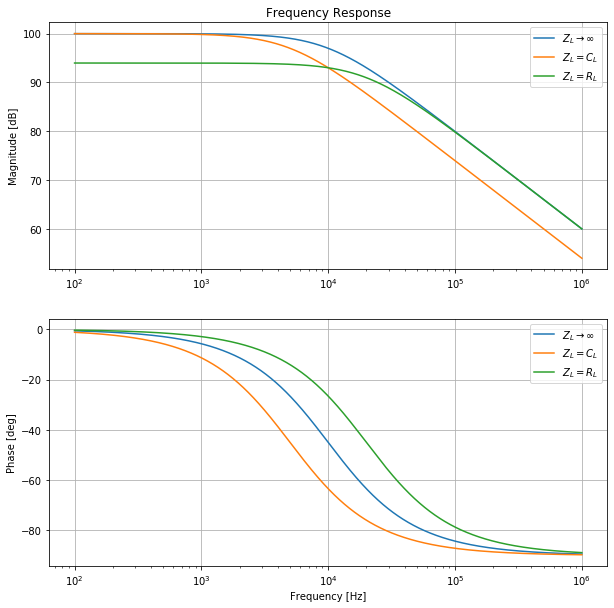

In [6]:
f = np.linspace(100,1e6,1000000)
w = 2*np.pi*f
H1 = 1/((1/R1)+1j*w*C2)
H2 = 1/((1/R1)+1j*w*2*C2)   # Z_L = C_L -> smaller cutoff
H3 = 1/((1/(R1/2)+1j*w*C2)) # Z_L = R_L -> larger cutoff and smaller lowpass magnitude; R_L = R_out

fig, axs = plt.subplots(2,figsize=(10,10))
axs[0].set_title(r'Frequency Response')
axs[0].semilogx(f, 20*np.log10(abs(H1)), label=r'$Z_L \rightarrow \infty$')
axs[0].semilogx(f, 20*np.log10(abs(H2)), label=r'$Z_L = C_L$')
axs[0].semilogx(f, 20*np.log10(abs(H3)), label=r'$Z_L = R_L$')
axs[0].set_ylabel('Magnitude [dB]')
axs[0].legend()
axs[0].grid()

axs[1].semilogx(f, np.angle(H1,deg=True), label=r'$Z_L \rightarrow \infty$')
axs[1].semilogx(f, np.angle(H2,deg=True), label=r'$Z_L = C_L$')
axs[1].semilogx(f, np.angle(H3,deg=True), label=r'$Z_L = R_L$')
axs[1].set_ylabel('Phase [deg]')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].legend()
axs[1].grid()
plt.show();

**Part C**

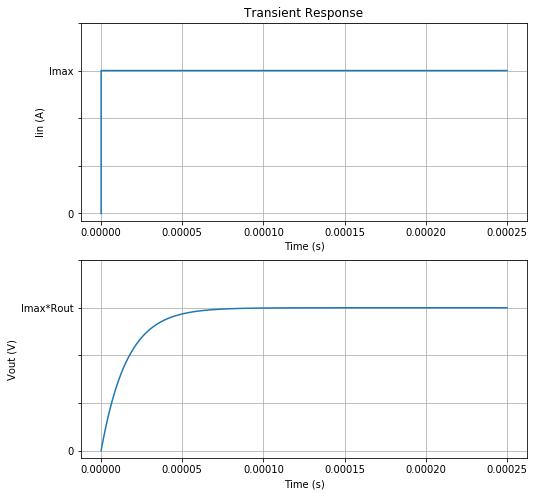

In [7]:
t = np.linspace(0,0.00025,100000)
step = 3*np.ones(len(t)-1)
x = [0]+step.tolist()
Tau = R1*C2
y = x*(1-np.exp(-t/Tau))
fig, axs = plt.subplots(2,figsize=(8,8))


axs[0].set_title('Transient Response')
axs[0].step(t,x)
axs[0].set_ylabel('Iin (A)')
axs[0].set_xlabel('Time (s)')
axs[0].set_yticks([0,1,2,3,4])
axs[0].set_yticklabels(['0','','','Imax',''])
axs[0].grid()

axs[1].plot(t,y)
axs[1].set_ylabel('Vout (V)')
axs[1].set_xlabel('Time (s)')
axs[1].set_yticks([0,1,2,3,4])
axs[1].set_yticklabels(['0','','','Imax*Rout',''])
axs[1].grid()
plt.show();

<hr>

<img src="images/Q3.png" width="600">

**Part A**

Maximum clock frequency is defined by the smallest clock period that satisfies the precision settling time.

Given: $0.1\%\text{ precision settling time } \rightarrow  t_{\text{settle}} \geq -\ln{(0.001)} \approx 6.9\tau$

In low pass filter, $\tau = RC = (100)(10\cdot 10^{-12}) = 10^{-9}s$, thus $t_{\text{settle}} = 6.9 \tau = 6.9\text{ns}$

$\begin{eqnarray}
T_{\text{clk}}(50\% \text{ duty cycle}) =& \frac{1}{2f_{\text{clk}}} \\
t_{\text{settle}}                       =& \frac{1}{2f_{\text{clk}}} \\
f_{\text{clk}}                          =& \frac{1}{2\cdot 6.9 \cdot 10^{-9}} \\
\\
f_{\text{clk}}                          =& 7.246 \cdot 10^7
\end{eqnarray}$

The maximum clock frequency is $72.46 \text{ MHz}$.

**Part B**

The capacitor reactance $\frac{1}{jwC}$ becomes very small at high frequecies and the voltage across the capacitor approaches $V_{\text{in}}=1$V. Since the capacitor is never discharged, the average current delivered to the capacitor is zero as $t$ approaches infinity.

**Part C**

<img src="images/Q3c_ltspice.png" width="600">

In [8]:
filepath = 'data/Q3.txt'
df = read_ltspice_tran(filepath)
df = df[df['time']<10e-9]

In [9]:
v = 1-np.exp(-6.9)
print(f'Vcap theoretical voltage is {round(v,6)}V at 6.9ns')

time = df['time'].to_numpy()
x0 = np.where(time<=7e-9)[0][-1]
v = df.iloc[x0]['V(vcap)']
i = df.iloc[x0]['I(C1)']
t = df.iloc[x0]['time']
print(f'Vcap simulated voltage is {v}V at {RoundNonZeroDecimal(t,4)}s')

Vcap theoretical voltage is 0.998992V at 6.9ns
Vcap simulated voltage is 0.9990016V at 6.9e-09s


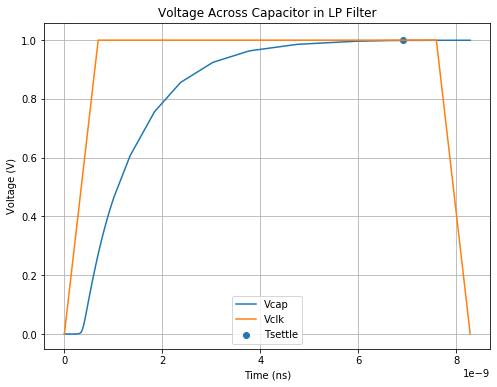

In [10]:
fig, ax = plt.subplots(1,figsize=(8,6))
ax.set_title('Voltage Across Capacitor in LP Filter')
ax.plot(df['time'], df['V(vcap)'],label='Vcap')
ax.plot(df['time'], df['V(n001)'],label='Vclk')
ax.scatter(t,v,label='Tsettle')
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (ns)')
ax.grid()
ax.legend()
plt.show();

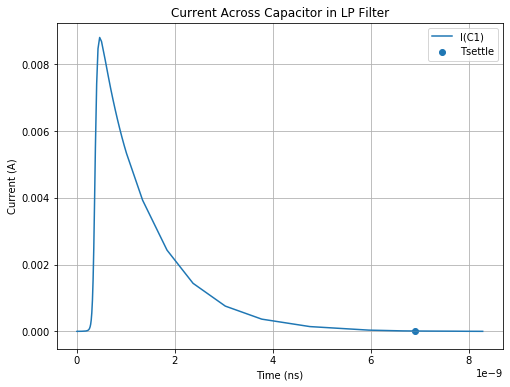

In [11]:
fig, ax = plt.subplots(1,figsize=(8,6))
ax.set_title('Current Across Capacitor in LP Filter')
ax.plot(df['time'], df['I(C1)'],label='I(C1)')
ax.scatter(t,i,label='Tsettle')
ax.set_ylabel('Current (A)')
ax.set_xlabel('Time (ns)')
ax.grid()
ax.legend()
plt.show();

**Part D**

<img src="images/Q3d_ltspice.png" width="300">

In [12]:
filepath = 'data/Q3_ACanalysis.txt'
df = read_ltspice_tran(filepath)
df['Vcap_Mag'] = df['V(vcap)'].apply(lambda x: x.split(',')[0])
df['Vcap_Mag'] = df['Vcap_Mag'].apply(lambda x: x[1:-2])
df['Vcap_Mag'] = df['Vcap_Mag'].astype('float64')
df['Vcap_Phase'] = df['V(vcap)'].apply(lambda x: x.split(',')[1])
df['Vcap_Phase'] = df['Vcap_Phase'].apply(lambda x: x[1:-2])
df['Vcap_Phase'] = df['Vcap_Phase'].astype('float64')
df['Freq.'] = df['Freq.'].astype('float64')

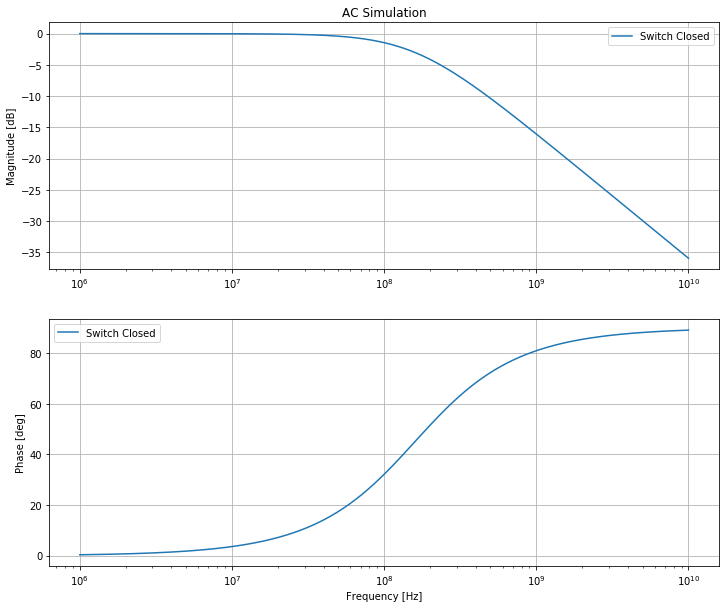

In [13]:
fig, axs = plt.subplots(2,figsize=(12,10))
f = df['Freq.']
mag = df['Vcap_Mag']
ang = df['Vcap_Phase']

axs[0].set_title('AC Simulation')
axs[0].semilogx(f, mag, label='Switch Closed')
axs[0].set_ylabel('Magnitude [dB]')
axs[0].grid()
axs[0].legend()
axs[1].semilogx(f, ang, label='Switch Closed')
axs[1].set_ylabel('Phase [deg]')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].grid()
axs[1].legend()
plt.show();

The transfer function is a single pole characterized by $\omega_{\text{cutoff}} = \frac{1}{\tau} =\frac{1}{RC}$. Notice this is inversly proportional to $t_\text{settle} = 6.9\tau = 6.9\text{RC}$. If $RC$ is small, then the $\omega_{\text{cutoff}}$ will occur at a greater frequency and $t_\text{settle}$ will be shorter. Likewise, if $RC$ is large, then the cutoff will occur at a smaller frequency and $t_\text{settle}$ will be longer.